In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import pandas as pd
from IPython.display import display, HTML

In [5]:
def find_expenditures_fundamt():
    """Read in the "truth" containing expenditures per year and amount left in fund each year"""
    p = pd.read_csv('data/Expenditures.csv')
    d = p.set_index('Year').to_dict()
    expenditures = d['Average monthy payment ']
    amount_in_fund = d['Amount in Fund']
    return expenditures, amount_in_fund

def find_incomes(workers):
    """Finds the average income of the people in the workers bucket per year"""
    p = pd.read_csv('data/Income_67.csv')
    p['Age_Group'] = 'O'
    p.loc[np.logical_and(p['AGE GROUP LOWER'] >= workers[0],p['AGE GROUP UPPER'] <= workers[1]), 'Age_Group'] = 'W'
    del p['AGE GROUP UPPER']
    del p['AGE GROUP LOWER']
    pop = p.groupby(['Year',"Age_Group"]).mean()
    return pop.to_dict()['MEDIAN INCOME']

def income_line_of_best_fit(year,year_start,n_years,income_data):
    """Use income data if available, otherwise interpolate data through a line of best fit"""
    x = range(1990,2016)
    if year in x: #if we already have the data for this year, return known value
        return income_data[(year,'W')]
    else: #otherwise, we interpolate
        y = []
        years = [year-i for i in range(1,3)]
        for i in range(1,3):
            y.append(income_data[(year-i,'W')])
        line = np.poly1d(np.polyfit(years, y, 1))
        return line[0] + line[1]*year
            
def retiree_line_of_best_fit(year,year_start,n_years,pop_data):
    """Use retiree population data if available, otherwise interpolate data through a line of best fit"""
    if year in data_range: #if we already have the data for this year, return known value
        return pop_data[(year,'R')]
    else: #otherwise, we interpolate
        y = []
        years = [year-i for i in range(1,3)]
        for i in range(1,3):
            y.append(pop_data[(year-i,'R')])
        line = np.poly1d(np.polyfit(years, y, 1))
        return line[0] + line[1]*year
    
def worker_line_of_best_fit(year,year_start,n_years,pop_data):
    """Use worker population data if available, otherwise interpolate data through a line of best fit"""
    x = range(1990,2016)
    if year in data_range:
        return pop_data[(year,'W')]
    else:
        y = []
        years = [year-i for i in range(1,3)]
        for i in range(1,3):
            y.append(pop_data[(year-i,'W')])
        line = np.poly1d(np.polyfit(years, y, 1))
        return line[0] + line[1]*year
    
def fundamt_line_of_best_fit(year,year_start,n_years,fundamt):
    """Use fund data if available, otherwise interpolate data through a line of best fit"""
    x = range(1990,2016)
    if year in x:
        return fundamt[year]
    else:
        y = []
        years = [year-i for i in range(1,3)]
        for i in range(1,3):
            y.append(fundamt[year-i])
        line = np.poly1d(np.polyfit(years, y, 1))
        return line[0] + line[1]*year
    
def expenditure_line_of_best_fit(year,year_start,n_years,expenditures):
    """Use expenditure data if available, otherwise interpolate data through a line of best fit"""
    x = range(1990,2016)
    if year in x:
        return expenditures[year]
    else:
        y = []
        years = [year-i for i in range(1,3)]
        for i in range(1,3):
            y.append(expenditures[year-i])
        line = np.poly1d(np.polyfit(years, y, 1))
        return line[0] + line[1]*year

In [7]:
def simulator(workers_range, age_of_retirement, percent_given_to_govt, starting_year, number_years):
    """Calculates amt_in_fund + percent_given_to_govt*average_income*#workers - average_expenditure/month*12*#retirees"""
    pop_data = find_worker_retiree_populations(workers_range, age_of_retirement)
    expenditures, fundamt = find_expenditures_fundamt()

    starting_amt_in_fund = fundamt[starting_year]
    fund_amount = [starting_amt_in_fund]
    incomes_dictionary = find_incomes(workers_range)
    
    for i in range(number_years):
        """Call functions that interpolate if needed and update"""
        workers = worker_line_of_best_fit(starting_year+i+1,starting_year,number_years,pop_data)
        retirees = retiree_line_of_best_fit(starting_year+i+1,starting_year,number_years,pop_data)
        income = income_line_of_best_fit(starting_year+i+1,starting_year,number_years,incomes_dictionary)
        pop_data[(starting_year+i+1,'R')] = retirees
        pop_data[(starting_year+i+1,'W')] = workers
        incomes_dictionary[(starting_year+i+1,'W')] = income
            
        expend = expenditure_line_of_best_fit(starting_year+i+1,starting_year,number_years,expenditures)
        expenditures[starting_year+i+1] = expend
        
        """Calculate amount coming in and going out"""
        coming_in = percent_given_to_govt*income*workers
        going_out = expend*12*retirees
        fund_amount.append(fund_amount[-1] + coming_in - going_out) #update fund amt
        
        if fund_amount[-1] <= 0: #if fund ran out, return the year
            return fund_amount, starting_year+i+1
    
    return fund_amount, 0


def run_simulator(start_year,filename,workers=[15,64],retirement_age=65,rate=0.1052,n_years=500):
    fund_hypothetical, end_year = simulator(workers, retirement_age, rate, start_year, n_years)
    
    fund_actual = []
    x, amt_in_fnd = find_expenditures_fundamt()
    for i in range(1990,2016):
        fund_actual.append(amt_in_fnd[i])

    if end_year != 0:
        print "Fund Ran Out in: ", end_year
        plt.plot(range(1990,2016), fund_actual, color='red', label = "Actual Fund Amount")
        plt.plot(range(year_start,end_year+1), fund_hypothetical, color='green', label='Predicted Fund Amount')
        leg = plt.legend(loc = 'lower right')
    
    else:
        plt.plot(range(1990,2016), fund_actual, color='red', label = "Actual Fund Amount")
        plt.plot(range(year_start,year_start+n_years+1), fund_hypothetical, color='green', label='Predicted Fund Amount')
        leg = plt.legend(loc = 'lower right')
    plt.savefig(filename+'.png' ,bbox_extra_artists=(leg,), bbox_inches='tight')

In [8]:
def find_worker_retiree_populations(workers, retirees):
    """Produces dictionary: (year, group)-> population where groups are 'W','R', or 'C'"""
    global data_range 
    
    p = pd.read_csv('data/PDE/pde_project_from_2015_retirement_age_67.csv')
    p['Age_Group'] = 'O'
    p.loc[np.logical_and(p['AGELOW'] >= workers[0],p['AGEHIGH'] <= workers[1]), 'Age_Group'] = 'W'
    p.loc[p['AGEHIGH'] < workers[0], 'Age_Group'] = 'C'
    p.loc[p['AGELOW'] >= retirees, 'Age_Group'] = 'R'  
    del p['AGEHIGH']
    del p['AGELOW']
    del p['Unnamed: 0']
    
    pop = p.groupby(['YEAR',"Age_Group"]).sum()
    data_range = range(min(p['YEAR']),max(p['YEAR'])+1)
    return pop.to_dict()['POPPROJ']


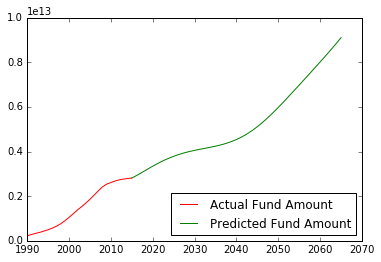

In [17]:
year_start = 2015
n_years = 50
rate = 0.1052
run_simulator(start_year=year_start,filename='increased_retirement',workers=[15,66],retirement_age=67,rate=rate,n_years=n_years)

Fund Ran Out in:  2030


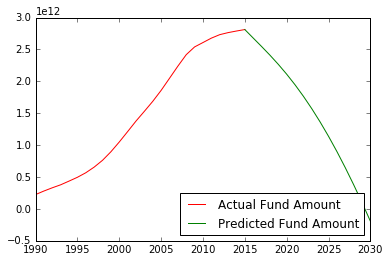

In [18]:
year_start = 2015
n_years = 50
rate_decrease = 0.3
rate = 0.1052*(1-rate_decrease)
run_simulator(start_year=year_start,filename='increased_retirement_'+str(rate_decrease),workers=[15,66],retirement_age=67,rate=rate,n_years=n_years)

Fund Ran Out in:  2037


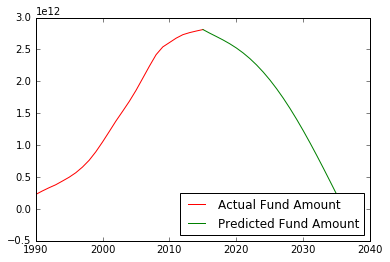

In [19]:
year_start = 2015
n_years = 50
rate_decrease = 0.2
rate = 0.1052*(1-rate_decrease)
run_simulator(start_year=year_start,filename='increased_retirement_'+str(rate_decrease),workers=[15,66],retirement_age=67,rate=rate,n_years=n_years)